In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import numpy as np
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv("customers_churn.csv")

In [4]:
data.dtypes

State              object
Account_Length      int64
Area_Code           int64
Phone              object
Intl_Plan          object
VMail_Plan         object
VMail_Message       int64
Day_Mins          float64
Day_Calls           int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
total_Mins        float64
Intl_Calls          int64
Intl_Charge       float64
Total_Charge      float64
CustServ_Calls      int64
Churn               int64
dtype: object

In [5]:
# Remove the State and Phone categoricals, separate y from X
X = data.drop(columns=["Churn", "State", "Phone"])
y = data["Churn"]

In [ ]:
# Convert "yes" to 1 and "no" to 0 in VMail_Plan, Intl_Plan features
#
# your code here...


In [11]:
X['VMail_Plan'] = X['VMail_Plan'].replace({'yes': 1, 'no': 0})
X['Intl_Plan'] = X['Intl_Plan'].replace({'yes': 1, 'no': 0})

print(data[['VMail_Plan', 'Intl_Plan']].head())

   VMail_Plan  Intl_Plan
0           1          0
1           1          0
2           0          0
3           0          1
4           0          1


In [12]:
y.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

As you can see, this is an unbalanced dataset with "0" (negative) rate of 85%.
This means that whatever we get from the learning algorithm, if it is less than 85% then it is worthless, because we could get that simply by predicting "0".

In [13]:
# Split dataset into training set and test set with 70%-30%

# ...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

y_value_counts = y.value_counts()
print(y_value_counts)

0    2850
1     483
Name: Churn, dtype: int64


In [14]:
# Create Decision Tree classifier object - no restrictions for now
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=None)

# Your code below - fit the model
#...
tree = clf.fit(X_train, y_train) # Assigning the result to a variable tree will allow us to view the tree

In [15]:
# Print the test accuracy and the train accuracy
# your code here
# ...
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.941


There is probably a bit of overfitting.  Let us view the tree.

In [21]:
from sklearn.tree import export_graphviz
import pydotplus

# This will create a .dot file, which is a standard for representing trees.
# Feel free to open it and view it (it is textual)
export_graphviz(tree, out_file="tree.dot",
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X_train.columns,
                class_names=['0','1'])
import pydotplus # for viewing .dot files
pydotplus.graph_from_dot_file("tree.dot").write_png('tree.png')

True

### Inspecting the tree visually
Open the file tree.png that was created, and view it with your favorite viewer.  The resulting tree is extremely complex, and you may need a zoom-in tool to see what's going on.  The first thing to note is that the algorithm uses the "gini" index to decide whether to split a node.  Each node in the tree is annotated with the Gini index. This is because by default, the algorithm uses the "gini" criterion.  If you look at the documentation, you shall see that this criterion can be changed in the arguments of DecisionTreeClassifier, using the keyword criterion="entropy" for Information Gain as we learned in class.  
Additionally, each node is also annotated with the number of training examples falling in the region defined by the node, and also with a count of the number of "0" and number of "1"'s in the training set in that region ("value" in the picture), which can be used for soft prediction. Finally you will see "class" which is the hard prediction.
 If you inspect the leaves, you will see that they are all pure, which happens because we enforced no limits on the output tree.

To fight the overfitting, we may want to limit the tree in some way.  max_depth is a typical way.  Let's try it.

In [22]:
# Create Decision Tree classifier object with depth at most 2
clf_restricted = DecisionTreeClassifier(max_depth=2)

# Fit the model with the restricted depth
tree_restricted = clf_restricted.fit(X_train, y_train)


In [23]:
export_graphviz(tree, out_file="tree2.dot",
                filled=True, rounded=True,
                special_characters=True,
                class_names=['0','1'],
                feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_file("tree2.dot").write_png('tree2.png')
# View the resulting tree2.png, compare to tree.png

Let's look at the training and validation error.

In [24]:
# Your code here for printing training and validation error
# Calculating training and test errors
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

print(f"Training Error: {train_error}")
print(f"Test Error: {test_error}")


Training Error: 0.0
Test Error: 0.05900000000000005


### The sweet spot plot: Visualizing overfitting
In this exercise we will go back to the binary classification problem, and we shall vary the max-depth parameter from 1 to 20. For each value of max-depth, we will run k-fold cross validation on the decision tree classifier, in order to get a low-variance estimate of both the training and of the validation error.  Finally, we will plot both the training and validation errors and see what we get.

We will use sklean's model_selection.KFold for performing the K-fold management.  There are other options, for example model_selection.cross_val_score, but the "KFold" option gives us low-level control over the process, which we need for this case.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


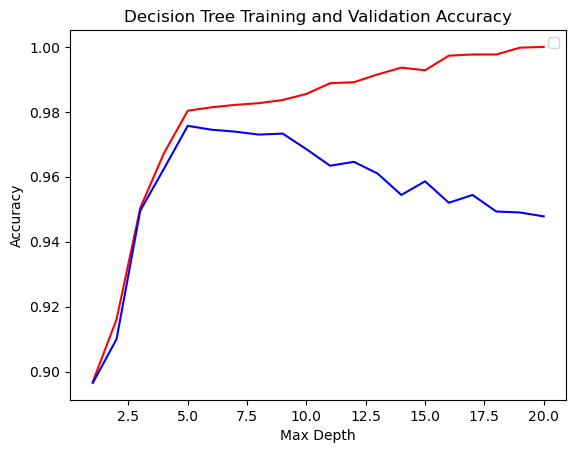

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
max_depth_vals = range(1,21)
train_accuracies = []
test_accuracies = []
n_splits = 5
for max_depth in max_depth_vals:
  kf = KFold(n_splits=n_splits, shuffle=True)
  av_train_accuracy = 0.0
  av_test_accuracy = 0.0
  for i, (train_index, val_index) in enumerate(kf.split(X)):
    # train_index is series of indices of training set
    # test_index is series of indices of the test set
    # you can use them to extract a training and test index for the current fold
    # your code here to extract a train, val dataframes
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[val_index]
    # ....
    clf = DecisionTreeClassifier(max_depth = max_depth)
    # Your code here... fit clf on the extracted train, test dataset
    # Then compute train_accuracy and test_accuracy
    # ...
    # ...
    clf.fit(X_train_kf, y_train_kf)
    y_train_pred = clf.predict(X_train_kf)
    y_test_pred = clf.predict(X_test_kf)
    train_accuracy = accuracy_score(y_train_kf, y_train_pred)
    test_accuracy = accuracy_score(y_test_kf, y_test_pred)
        

    av_train_accuracy += train_accuracy / n_splits
    av_test_accuracy  += test_accuracy / n_splits
  train_accuracies.append(av_train_accuracy)
  test_accuracies.append(av_test_accuracy)
plt.plot(max_depth_vals, train_accuracies, 'r') # train curve in red
plt.plot(max_depth_vals, test_accuracies, 'b')#test curve in blue
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Training and Validation Accuracy')
plt.legend()
plt.show()

## Write down your conclusions, insights, and further ideas below

There's an optimal tree depth that balances the model's complexity with its ability to generalize, evident from the peak in validation accuracy. Deep trees tend to overfit, as shown by higher training accuracies but lower validation accuracies, indicating the model captures noise in the training data.

We can use cross-validation to tune other hyperparameters, improving model performance without increasing complexity unnecessarily.
In addition, we could explore ensemble models like Random Forests or Gradient Boosting for better generalization and robustness against overfitting.